In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [22]:
df = pd.read_pickle('../../../cooked_data/caluire_2011_2021_monthly.pickle')
result_mul = seasonal_decompose(df['1340'], model = 'multiplicative', period = 12)

In [33]:
def predict(df, length):
    '''
    Input:
    - time serie                      (pd.serie)
    - forecast length in months       (int)
    
    It performs an ARIMA prediction of the time series for the next 'length' months.
    
    Returns:
    - forecast serie                  (pd serie)
    - lower confidence interval serie (pd serie)
    - upper confidence interval serie (pd serie)
    '''
    # Multiplicative seasonal decomposition
    result_mul = seasonal_decompose(df['1340'], model = 'multiplicative', period = 12)
    df['deseasonalized'] = df['1340'].values/result_mul.seasonal
    # Log-linearization
    df['linearized'] = np.log(df['deseasonalized'])
    print(df['linearized'])

    df = df['linearized']
    p, d, q = 3, 1, 2
    
    # Model
    arima = ARIMA(df, order=(p,d,q)).fit()
    forecast, std_err, confidence_int = arima.forecast(length, alpha=0.05)
    
    # Exponentialization and reseasonalization
    forecast = np.exp(forecast)*result_mul.seasonal[-length:]
    lower = np.exp(confidence_int)[:,0]*result_mul.seasonal[-length:]
    upper = np.exp(confidence_int)[:,1]*result_mul.seasonal[-length:]
    return forecast, lower, upper

In [34]:
fore_12 = predict(df, 12)

date
2011-11-01    2.323110
2011-12-01    2.105789
2012-01-01    2.188853
2012-02-01    2.310927
2012-03-01    2.143733
                ...   
2021-04-01    2.257137
2021-05-01    2.210058
2021-06-01    2.265942
2021-07-01    2.385226
2021-08-01    2.764124
Freq: MS, Name: linearized, Length: 118, dtype: float64


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96652D-02    |proj g|=  7.27421D+00

At iterate    5    f= -7.54698D-02    |proj g|=  8.88865D-02

At iterate   10    f= -7.56910D-02    |proj g|=  1.23953D+00

At iterate   15    f= -7.64437D-02    |proj g|=  2.52713D-03

At iterate   20    f= -7.64943D-02    |proj g|=  4.29437D-03

At iterate   25    f= -7.65315D-02    |proj g|=  1.36074D-01

At iterate   30    f= -7.65571D-02    |proj g|=  3.83087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


In [25]:
forecast = fore_12[0]
lower = fore_12[1]
upper = fore_12[2]

In [28]:
df['1340']

date
2011-11-01    11.1
2011-12-01    11.1
2012-01-01    13.0
2012-02-01    13.0
2012-03-01    10.6
              ... 
2021-04-01    10.5
2021-05-01     9.1
2021-06-01     8.9
2021-07-01     7.9
2021-08-01     8.7
Freq: MS, Name: 1340, Length: 118, dtype: float64

In [30]:
forecast

date
2020-09-01     6.555290
2020-10-01     7.890158
2020-11-01    10.635301
2020-12-01    12.371106
2021-01-01    13.070258
2021-02-01    11.225696
2021-03-01    10.797518
2021-04-01     9.395075
2021-05-01     8.563721
2021-06-01     7.837704
2021-07-01     6.202321
2021-08-01     4.640282
Freq: MS, Name: seasonal, dtype: float64

In [6]:
print(type(forecast))
print(type(upper))
print(type(lower))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [19]:
def plot_24(df, length, forecast, upper=None, lower=None):
    
    df = df['1340']
    df = df[-24:]
    forecast = forecast.values
    lower = lower.values
    upper = upper.values
    index = df.index[-length:] + df.index.freq*length
    
    forecast_series = pd.Series(forecast, index = index)
    lower_series = pd.Series(upper, index = index)
    upper_series = pd.Series(lower, index = index)
    
    plt.figure(figsize = (10,4), dpi = 100)
    plt.plot(df, label = f'Nitrates concentration of last 24 months', color = 'black')
    plt.plot(forecast_series, label = 'Forecast', color = 'orange', ls = '--')
    plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = 0.15)
    plt.title(f'Forecast for the next {length} months')
    plt.legend(loc = 'upper left', fontsize = 8)    

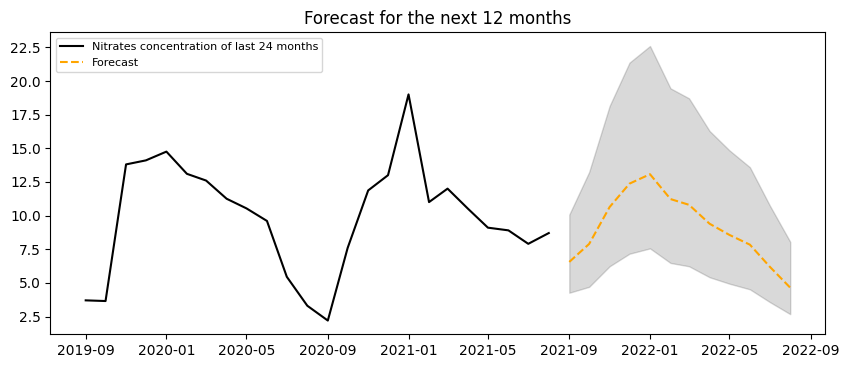

In [20]:
plot_24(df, 12, forecast, lower, upper)

In [ ]:
def plot_forecast(train, length, fc, upper=None, lower=None):
    index = train.index[-length:] + train.index.freq*length
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=index)
    lower_series = pd.Series(upper, index=index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [ ]:
plot_forecast(df['1340'], 12, forecast.values, lower, upper)